In [9]:
# Install new packages
# !pip install tensorflow==2.3 
# !pip install tensorflow-probability

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import time

# AWS
import sagemaker
import s3fs

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.backend import random_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.regularizers import L1
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_probability as tfp

In [11]:
# Daniel Jeong model implementation
# Baseline CNN for Emotion Detection
class EmotionCNN:
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Input layer
        input_img = Input(shape=(48,48,1), name='input_img')

        # Convolution Layers
        h = Conv2D(16, (3,3), padding='same', activation='relu')(input_img)
        h = MaxPooling2D((2,2))(h)
        h = Conv2D(32, (3,3), padding='same', activation='relu')(h)
        h = MaxPooling2D((2,2))(h)
        h = Conv2D(64, (3,3), padding='same', activation='relu')(h)
        h = MaxPooling2D((2,2))(h)
        h = Flatten()(h)
        h = Dense(10, name='emotion_pred')(h)

        # Define full model
        self.model = Model(inputs=input_img, outputs=h, name='EmotionCNN')

        # Compile model
        self.model.compile(optimizer=Adam(), loss=categorical_crossentropy)

    def fit(self, inputs, labels, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)

    def summary(self):
        self.model.summary()


# CNN for Joint Bounding Box and Emotion Detection
class EmotionBBCNN:
    def __init__(self):
        super(EmotionBBCNN, self).__init__()

        # Input layer
        input_img = Input(shape=(48,48,1), name='input_img')

        # Convolution Layers
        h = Conv2D(32, (3,3), padding='same', activation='relu')(input_img)
        h = MaxPooling2D((2,2))(h)
        h = Conv2D(64, (3,3), padding='same', activation='relu')(h)
        h = MaxPooling2D((2,2))(h)
        h = Conv2D(128, (3,3), padding='same', activation='relu')(h)
        h = MaxPooling2D((2,2))(h)
        h = Flatten()(h)

        # Emotion prediction
        emotion = Dense(10, name='emotion_pred')(h)

        # Bounding box prediction
        bb = Dense(4, name='bb_pred')(h)

        # Define full model
        self.model = Model(inputs=input_img, outputs=[emotion, bb], name='EmotionBBCNN')

        # Compile model
        losses = {'emotion_pred': emotion,
                  'bb_pred': bb}

        # TODO: Need to check how to adjust the weights to match scale
        loss_weights = {'emotion_pred': 1.0,
                        'bb_pred': 1.0}

        metrics = {'emotion_pred': categorical_accuracy}

        self.model.compile(optimizer=Adam(), loss=losses, loss_weights=loss_weights, metrics=metrics)

    def fit(self, inputs, labels, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)

    def summary(self):
        self.model.summary()


# AutoEncoder
class AE:
    def __init__(self):
        super(AE, self).__init__()
    
        # Input layer
        self.input_img = Input(shape=(48,48,1), name='input_img')
        
        # Encoder
        self.encoder = Sequential([
            Conv2D(16, (3,3), padding='same', activation='relu'),
            MaxPooling2D((2,2)),
            Conv2D(32, (3,3), padding='same', activation='relu'),
            MaxPooling2D((2,2)),
            Conv2D(64, (3,3), padding='same', activation='relu'),
            MaxPooling2D((2,2))
        ], name='encoderAE')
        
        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(16, (3,3), strides=2, padding='same',
                            activation='relu'),
            Conv2DTranspose(32, (3,3), strides=2, padding='same',
                            activation='relu'),
            Conv2DTranspose(64, (3,3), strides=2, padding='same',
                            activation='relu'),
            Conv2D(1, (3,3), padding='same', activation='sigmoid')
        ], name='decoderAE')
        
        # Define full model
        self.encodings = self.encoder(self.input_img)
        self.decodings = self.decoder(self.encodings)
        self.model = Model(inputs=self.input_img, outputs=self.decodings)
        
        # Compile model
        self.model.compile(optimizer=Adam(), loss='mse')
        
    def fit(self, inputs, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, inputs, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)
        
    def get_encoder(self):
        encoder = Model(inputs=self.model.get_layer('encoderAE').input,
                        outputs=self.model.get_layer('encoderAE').output)
        
        return encoder
    
    def get_decoder(self):
        decoder = Model(inputs=self.model.get_layer('decoderAE').input,
                        outputs=self.model.get_layer('decoderAE').output)
        
        return decoder
        
    def summary(self):
        self.model.summary()
        
    def encoder_summary(self):
        encoder = self.get_encoder()
        encoder.compile()
        encoder.summary()
        
    def decoder_summary(self):
        decoder = self.get_decoder()
        decoder.compile()
        decoder.summary()
        
    def encode(self, inputs):
        encoder = self.get_encoder()
        encodings = encoder.predict(inputs)
        
        return encodings
    
    def decode(self, inputs):
        decoder = self.get_decoder()
        decodings = decoder.predict(inputs)
        
        return decodings

# Sampling layer with reparameterization trick
class Sampling(Layer):
    def __init__(self, name=None):
        super(Sampling, self).__init__(name=name)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        latent_dims = tf.shape(z_mean)[1]

        # Reparameterization Trick
        epsilon = random_normal(shape=(batch_size, latent_dims))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Scaled MSE
# Note: 900 = ~(28709 / 32)
def scaled_mse(y_true, y_pred, w=900):
    return w * mean_squared_error(y_true, y_pred)

# Variational AutoEncoder (VAE)
# Note: Providing a beta term makes it a beta-VAE
class VAE:
    def __init__(self, latent_dims, beta=1):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims

        # Encoder
        encoder_input = Input(shape=(48,48,1), name='encoder_input')
        e = Conv2D(16, (3,3), padding='same', activation='relu')(encoder_input)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(32, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(64, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Flatten()(e)

        z_mean = Dense(self.latent_dims, name='z_mean')(e)
        z_log_var = Dense(self.latent_dims, name='z_log_var')(e)
        z = Sampling(name='Sampling')((z_mean, z_log_var))

        self.encoder = Model(inputs=encoder_input, outputs=z, name='encoderVAE')

        # Decoder
        decoder_input = Input(shape=(latent_dims,), name='decoder_input')
        d = Dense(6*6*64, activation='relu')(decoder_input)
        d = Reshape(target_shape=(6,6,64))(d)
        d = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(d)
        d = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(d)
        d = Conv2DTranspose(16, (3,3), strides=2, padding='same', activation='relu')(d)
        d = Conv2DTranspose(1, (3,3), padding='same', activation='relu')(d)

        self.decoder = Model(inputs=decoder_input, outputs=d, name='decoderVAE')
        
        # Define full model
        output_img = self.decoder(z)
        self.model = Model(inputs=encoder_input, outputs=output_img, name='VAE')
        
        # Add KL loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1) * beta
        self.model.add_loss(kl_loss)

        # Compile model
        self.model.compile(optimizer=Adam(), loss=scaled_mse, metrics=[scaled_mse])
        
    def fit(self, inputs, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, inputs, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)
        
    def get_encoder(self):
        encoder = Model(inputs=self.model.input,
                        outputs=self.model.get_layer('Sampling').output)
        
        return encoder
    
    def get_decoder(self):
        decoder = Model(inputs=self.model.get_layer('decoderVAE').input,
                        outputs=self.model.get_layer('decoderVAE').output)
        
        return decoder
        
    def summary(self):
        self.model.summary()
        
    def encode(self, inputs):
        encoder = self.get_encoder()
        encodings = encoder.predict(inputs)
        
        return encodings
    
    def decode(self, inputs):
        decoder = self.get_decoder()
        decodings = decoder.predict(inputs)
        
        return decodings

# Variational AutoEncoder (VAE) with Emotion Decoder
# Note: Providing a beta term makes it a beta-VAE
# Note: Linear option changes emotion decoder to be linear for interpretability
class EmotionVAE:
    def __init__(self, latent_dims, beta=1, linear=False, sparse=False):
        super(EmotionVAE, self).__init__()
        self.latent_dims = latent_dims

        # Encoder
        encoder_input = Input(shape=(48,48,1), name='encoder_input')
        e = Conv2D(16, (3,3), padding='same', activation='relu')(encoder_input)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(32, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(64, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Flatten()(e)

        z_mean = Dense(self.latent_dims, name='z_mean')(e)
        z_log_var = Dense(self.latent_dims, name='z_log_var')(e)
        z = Sampling(name='Sampling')((z_mean, z_log_var))

        self.encoder = Model(inputs=encoder_input, outputs=z, name='encoderVAE')

        # Reconstruction Decoder
        recon_input = Input(shape=(latent_dims,), name='recon_input')
        d1 = Dense(6*6*64, activation='relu')(recon_input)
        d1 = Reshape(target_shape=(6,6,64))(d1)
        d1 = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(16, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(1, (3,3), padding='same', activation='relu', name='recon')(d1)

        self.recon_decoder = Model(inputs=recon_input, outputs=d1, name='reconDecoderVAE')
        
        # Emotion Decoder
        emotion_input = Input(shape=(latent_dims,), name='emotion_input')        

        if linear:
            if sparse:
                d2 = Dense(10, activation='softmax', name='emotion_pred',
                           kernel_regularizer=L1(l1=0.01))(emotion_input)
            else:
                d2 = Dense(10, activation='softmax', name='emotion_pred')(emotion_input)

        else:
            d2 = Dense(64, activation='relu')(emotion_input)
            d2 = Dense(32, activation='relu')(d2)
            d2 = Dense(10, activation='softmax', name='emotion_pred')(d2)
            
        self.emotion_decoder = Model(inputs=emotion_input, outputs=d2, name='emotionDecoderVAE')

        # Define full model
        output_img = self.recon_decoder(z)
        output_emotion = self.emotion_decoder(z)
        self.model = Model(inputs=encoder_input, outputs=[output_img, output_emotion], name='EmotionVAE')
        
        # Add KL loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1) * beta
        self.model.add_loss(kl_loss)

        # Compile model
        losses = {'reconDecoderVAE': scaled_mse,
                  'emotionDecoderVAE': categorical_crossentropy}

        loss_weights = {'reconDecoderVAE': 1.0,
                        'emotionDecoderVAE': 1.5}

        metrics = {'emotionDecoderVAE': categorical_accuracy}

        self.model.compile(optimizer=Adam(), loss=losses, loss_weights=loss_weights, metrics=metrics)
        
    def fit(self, inputs, labels, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)
        
    def get_encoder(self):
        encoder = Model(inputs=self.model.input,
                        outputs=self.model.get_layer('Sampling').output)
        
        return encoder
    
    def get_recon_decoder(self):
        recon_decoder = Model(inputs=self.model.get_layer('reconDecoderVAE').input,
                              outputs=self.model.get_layer('reconDecoderVAE').output)
        
        return recon_decoder

    def get_emotion_decoder(self):
        emotion_decoder = Model(inputs=self.model.get_layer('emotionDecoderVAE').input,
                                outputs=self.model.get_layer('emotionDecoderVAE').output)
        
        return emotion_decoder
        
    def summary(self):
        self.model.summary()
        
    def encode(self, inputs):
        encoder = self.get_encoder()
        encodings = encoder.predict(inputs)
        
        return encodings
    
    def decode(self, inputs):
        recon_decoder = self.get_recon_decoder()
        recon = recon_decoder.predict(inputs)

        emotion_decoder = self.get_emotion_decoder()
        emotion = emotion_decoder.predict(inputs)
        
        return recon, emotion

# Variational AutoEncoder (VAE) with Emotion + Bounding Box Decoders
# Note: Providing a beta term makes it a beta-VAE
# Note: Linear option changes emotion decoder to be linear for interpretability
class EmotionBBVAE:
    def __init__(self, latent_dims, beta=1, linear=False, sparse=False):
        super(EmotionBBVAE, self).__init__()
        self.latent_dims = latent_dims

        # Encoder
        encoder_input = Input(shape=(48,48,1), name='encoder_input')
        e = Conv2D(16, (3,3), padding='same', activation='relu')(encoder_input)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(32, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Conv2D(64, (3,3), padding='same', activation='relu')(e)
        e = MaxPooling2D((2,2))(e)
        e = Flatten()(e)

        z_mean = Dense(self.latent_dims, name='z_mean')(e)
        z_log_var = Dense(self.latent_dims, name='z_log_var')(e)
        z = Sampling(name='Sampling')((z_mean, z_log_var))

        self.encoder = Model(inputs=encoder_input, outputs=z, name='encoderVAE')

        # Reconstruction Decoder
        recon_input = Input(shape=(latent_dims,), name='recon_input')
        d1 = Dense(6*6*64, activation='relu')(recon_input)
        d1 = Reshape(target_shape=(6,6,64))(d1)
        d1 = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(16, (3,3), strides=2, padding='same', activation='relu')(d1)
        d1 = Conv2DTranspose(1, (3,3), padding='same', activation='relu', name='recon')(d1)

        self.recon_decoder = Model(inputs=recon_input, outputs=d1, name='reconDecoderVAE')
        
        # Emotion Decoder
        emotion_input = Input(shape=(latent_dims,), name='emotion_input')        

        if linear:
            if sparse:
                d2 = Dense(10, activation='softmax', name='emotion_pred',
                           kernel_regularizer=L1(l1=0.01))(emotion_input)
            else:
                d2 = Dense(10, activation='softmax', name='emotion_pred')(emotion_input)

        else:
            d2 = Dense(64, activation='relu')(emotion_input)
            d2 = Dense(32, activation='relu')(d2)
            d2 = Dense(10, activation='softmax', name='emotion_pred')(d2)
            
        self.emotion_decoder = Model(inputs=emotion_input, outputs=d2, name='emotionDecoderVAE')

        # Bounding Box Decoder
        bb_input = Input(shape=(latent_dims,), name='bb_input')
        d3 = Dense(32, activation='relu')(bb_input)
        d3 = Dense(4, name='bb_pred')(d3)

        self.bb_decoder = Model(inputs=bb_input, outputs=d3, name='bbDecoderVAE')

        # Define full model
        output_img = self.recon_decoder(z)
        output_emotion = self.emotion_decoder(z)
        output_bb = self.bb_decoder(z)
        self.model = Model(inputs=encoder_input, outputs=[output_img, output_emotion, output_bb], name='EmotionBBVAE')
        
        # Add KL loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1) * beta
        self.model.add_loss(kl_loss)

        # Compile model
        losses = {'reconDecoderVAE': scaled_mse,
                  'emotionDecoderVAE': categorical_crossentropy,
                  'bbDecoderVAE': mean_squared_error}

        loss_weights = {'reconDecoderVAE': 1.0,
                        'emotionDecoderVAE': 1.5,
                        'bbDecoderVAE': 1.0}

        metrics = {'emotionDecoderVAE': categorical_accuracy}

        self.model.compile(optimizer=Adam(), loss=losses, loss_weights=loss_weights, metrics=metrics)
        
    def fit(self, inputs, labels, epochs, batch_size, val_data=None, workers=1, callbacks=None):
        history = self.model.fit(inputs, labels, batch_size=batch_size, epochs=epochs,
                                 validation_data=val_data, workers=workers,
                                 callbacks=callbacks)
        
        return history

    def predict(self, inputs):
        return self.model.predict(inputs)
        
    def get_encoder(self):
        encoder = Model(inputs=self.model.input,
                        outputs=self.model.get_layer('Sampling').output)
        
        return encoder
    
    def get_recon_decoder(self):
        recon_decoder = Model(inputs=self.model.get_layer('reconDecoderVAE').input,
                              outputs=self.model.get_layer('reconDecoderVAE').output)
        
        return recon_decoder

    def get_emotion_decoder(self):
        emotion_decoder = Model(inputs=self.model.get_layer('emotionDecoderVAE').input,
                                outputs=self.model.get_layer('emotionDecoderVAE').output)
        
        return emotion_decoder

    def get_bb_decoder(self):
        bb_decoder = Model(inputs=self.model.get_layer('bbDecoderVAE').input,
                           outputs=self.model.get_layer('bbDecoderVAE').output)
        
    def summary(self):
        self.model.summary()
        
    def encode(self, inputs):
        encoder = self.get_encoder()
        encodings = encoder.predict(inputs)
        
        return encodings
    
    def decode(self, inputs):
        recon_decoder = self.get_recon_decoder()
        recon = recon_decoder.predict(inputs)

        emotion_decoder = self.get_emotion_decoder()
        emotion = emotion_decoder.predict(inputs)

        bb_decoder = self.get_bb_decoder()
        bb = bb_decoder.predict(inputs)
        
        return recon, emotion, bb

In [170]:
emotion_vae = EmotionVAE(100, linear=True, sparse=True)
emotion_vae.model.load_weights('s3://cellingt-ml-final-project/models/linear_sparse_emotion_vae_100epochs.ckpt')

In [105]:
# load data from s3
role = sagemaker.get_execution_role()
fs = s3fs.S3FileSystem()
bucket = 'cellingt-ml-final-project'

fer_plus = np.load(fs.open('s3://cellingt-ml-final-project/data/FER_plus/FER_plus.npz'))
dataset = np.load(fs.open('s3://cellingt-ml-final-project/data/FER_plus/linear_sparse_emotion_vae_embeddings.npz'))
list(dataset), list(fer_plus)

(['embeddings', 'labels', 'emotions'],
 ['xtrain', 'ytrain', 'xtest', 'ytest', 'xvalid', 'yvalid', 'labels'])

In [176]:
# FER+ test embeddings
test_faces = fer_plus['xtest'] / 255.0
yvals = fer_plus['ytest']
labels = fer_plus['labels']
pred_faces, pred_emotions = emotion_vae.predict(test_faces)
encoder = emotion_vae.get_encoder()
embeddings = encoder.predict(test_faces)
# embeddings = embeddings[:,:,:,0]
# embeddings, yvals, labels = dataset['embeddings'], dataset['labels'], dataset['emotions']
labels = {i:val for i, val in enumerate(labels)}
yvals_argmax = np.array([np.argmax(yval) for yval in yvals])

In [175]:
embeddings

array([[-1.6776874 ,  0.9211172 ,  0.33591473, ..., -1.8675681 ,
        -0.8141154 ,  0.6257118 ],
       [-0.6102931 , -0.5360124 ,  0.64807826, ...,  2.4797556 ,
        -0.20197175, -0.6185386 ],
       [-0.11577693,  0.44841412, -1.201767  , ...,  0.3686043 ,
        -0.2541476 , -1.2149733 ],
       ...,
       [ 2.7404978 ,  0.14257719, -0.32669684, ..., -1.0935711 ,
        -0.49583387,  0.533463  ],
       [-1.0568438 ,  0.60981286, -0.43785173, ...,  0.47140688,
        -1.1059768 ,  1.9847496 ],
       [-0.34837657, -1.2530037 ,  0.40455303, ..., -0.79909873,
        -0.04267126, -0.969278  ]], dtype=float32)

In [163]:
embeddings.shape, len(test_faces)

((3589, 100), 3589)

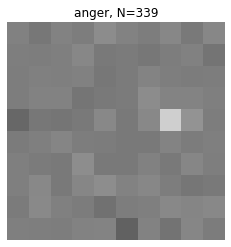

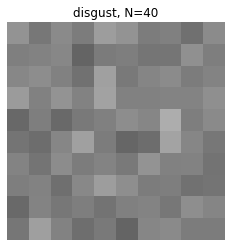

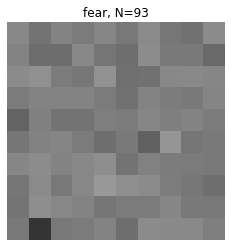

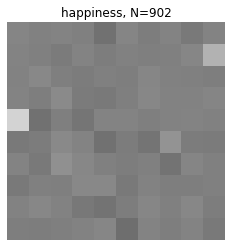

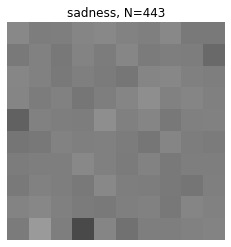

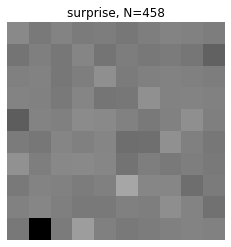

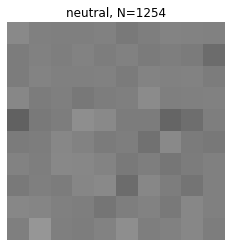

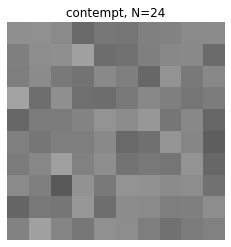

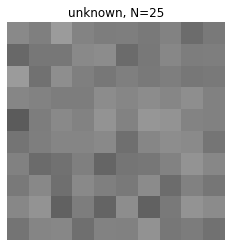

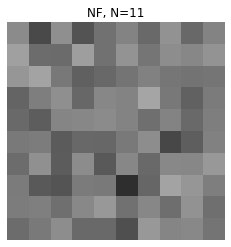

In [15]:
for e_id in np.unique(yvals_argmax):
    e_idx = yvals_argmax == e_id
    e_emb = embeddings[e_idx]
    e_emb_avg = np.mean(e_emb, axis=0).reshape((10,10))
    plt.imshow(e_emb_avg, cmap='gray', vmin=-2, vmax=2)
    plt.title(f"{labels[e_id]}, N={e_emb.shape[0]}")
    plt.axis('off')
    plt.show()

In [16]:
# kmeans

def edist(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

def kmeans(data, k):
    def get_centroids(data, clusters):
        centroids_new = np.zeros((k, data.shape[1]))
        for c_id in np.unique(clusters):
            c_idx = clusters == c_id
            c_data = data[c_idx]
            centroid = np.mean(c_data, axis=0)
            centroids_new[c_id] = centroid
        return centroids_new
    
    def assign_clusters(data, centroids):
        clusters_new = np.zeros(data.shape[0]).astype(int)
        for i, p in enumerate(data):
            c_dists = []
            for centroid in centroids:
                c_dists.append(edist(centroid, p))
            clusters_new[i] = np.argmin(c_dists)
        return clusters_new
    
    centroids = data[np.random.choice(np.arange(data.shape[0]), size=k)]
    clusters = np.zeros(data.shape[0])
    delta = 100
    while delta > 1e-2:
        clusters = assign_clusters(data, centroids)
        centroids_new = get_centroids(data, clusters)
        delta = np.mean([edist(c1, c2) for c1, c2 in zip(centroids, centroids_new)])
        print(delta)
        centroids = centroids_new
    return centroids, clusters
        

In [52]:
centroids, clusters = kmeans(embeddings, 7)

6.980431549439442
0.9309343265174538
0.7175196479293132
0.5501420318327409
0.40130758720299314
0.3236894897051155
0.28047359901081464
0.2482128290078187
0.19774135073587404
0.18082795390976658
0.1463123770795418
0.13539483513663228
0.10870877015915816
0.08995863283791201
0.08652305937047429
0.07898062947318449
0.0871415351752107
0.07885616009115903
0.07623545825008361
0.05387756357876795
0.06412105674562364
0.06008113219510145
0.048575828852528626
0.044715998110511204
0.03981656833009117
0.04388289718658872
0.04276067168874347
0.03772835936058653
0.02935175957489314
0.027451148529271472
0.0285280075182503
0.010186567609148172
0.011262579474166885
0.004712544545210326


In [53]:
# Get cluster purity:
for c_id in np.unique(clusters):
    c_idx = clusters == c_id
    c_yvals = yvals_argmax[c_idx]
    c_emo = np.argmax(np.bincount(c_yvals))
    c_purity = np.max(np.bincount(c_yvals)) / c_yvals.shape[0]
    print(f"Cluster{c_id}, majority {labels[c_emo]}, {np.round(c_purity,3)} purity, {c_yvals.shape[0]} elts")

Cluster0, majority surprise, 0.67 purity, 430 elts
Cluster1, majority happiness, 0.254 purity, 414 elts
Cluster2, majority neutral, 0.552 purity, 679 elts
Cluster3, majority neutral, 0.316 purity, 469 elts
Cluster4, majority happiness, 0.89 purity, 489 elts
Cluster5, majority neutral, 0.443 purity, 578 elts
Cluster6, majority neutral, 0.596 purity, 530 elts


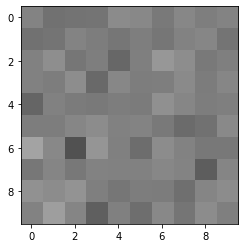

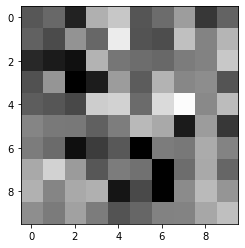

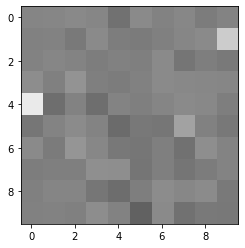

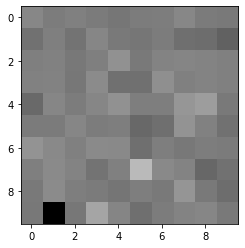

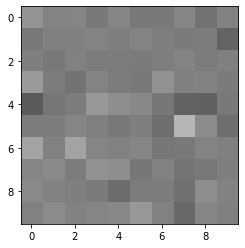

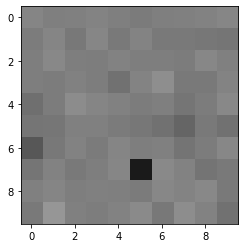

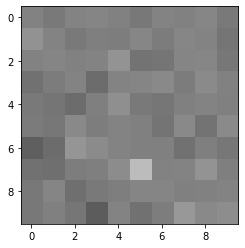

In [18]:
for centroid in centroids:
    plt.imshow(centroid.reshape((10,10)), cmap='gray', vmin=-2, vmax=2)
    plt.show()

In [19]:
def knn_test(data, data_labels, sample, ks):
    edists = [edist(sample, point) for point in data]
    k_consensus = []
    for k in ks:
        nn_idx = np.argsort(edists)[:k]
        nn_labels = data_labels[nn_idx]
        consensus = data_labels[np.argmax(np.bincount(nn_labels))]
        k_consensus.append(consensus)
    return np.array(k_consensus)

In [20]:
# LOOCV err
ks = range(1,101)
counts = np.zeros(len(ks))
for i in range(len(embeddings)-1):
    loo_idx = np.arange(len(embeddings)) != i
    k_consensus = knn_test(embeddings[loo_idx], yvals_argmax[loo_idx], embeddings[i], ks)
    truth = np.zeros(k_consensus.shape[0]) + yvals_argmax[i]
    counts += np.array(k_consensus == truth)
for k, count in zip(ks, counts):
    print(f"{k}-nn: {count / len(embeddings)}% acc")

1-nn: 0.2535525215937587% acc
2-nn: 0.27528559487322374% acc
3-nn: 0.2602396210643633% acc
4-nn: 0.26469768737809973% acc
5-nn: 0.25940373363053776% acc
6-nn: 0.2596823627751463% acc
7-nn: 0.2599609919197548% acc
8-nn: 0.2694343828364447% acc
9-nn: 0.26553357481192535% acc
10-nn: 0.2738924491501811% acc
11-nn: 0.2685984954026191% acc
12-nn: 0.27082752855948733% acc
13-nn: 0.2702702702702703% acc
14-nn: 0.26915575369183614% acc
15-nn: 0.26971301198105324% acc
16-nn: 0.27082752855948733% acc
17-nn: 0.2733351908609641% acc
18-nn: 0.27082752855948733% acc
19-nn: 0.26971301198105324% acc
20-nn: 0.27249930342713846% acc
21-nn: 0.27222067428252994% acc
22-nn: 0.2683198662580106% acc
23-nn: 0.2683198662580106% acc
24-nn: 0.2702702702702703% acc
25-nn: 0.2652549456673168% acc
26-nn: 0.26553357481192535% acc
27-nn: 0.2685984954026191% acc
28-nn: 0.26664809139035944% acc
29-nn: 0.26776260796879353% acc
30-nn: 0.2688771245472276% acc
31-nn: 0.2672053496795765% acc
32-nn: 0.2672053496795765% acc
33

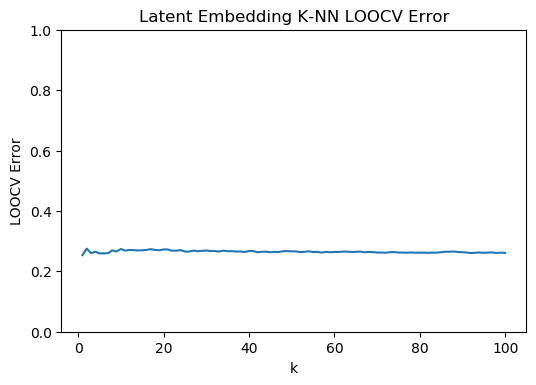

In [149]:
plt.figure(dpi=100)
plt.plot(ks, counts/len(embeddings), label='Accuracy')
plt.title("Latent Embedding K-NN Accuracy")
plt.xlabel('k')
plt.ylim(0,1)
plt.ylabel('LOOCV Error')
plt.savefig('knnacc.png')
plt.show()

In [154]:
centroids, clusters = kmeans(embeddings, 7)

# Get cluster purity:
for c_id in np.unique(clusters):
    c_idx = clusters == c_id
    c_yvals = yvals_argmax[c_idx]
    c_emo = np.argmax(np.bincount(c_yvals))
    c_purity = np.max(np.bincount(c_yvals)) / c_yvals.shape[0]
    print(f"Cluster{c_id}, majority {labels[c_emo]}, {np.round(c_purity,3)} purity, {c_yvals.shape[0]} elts")

ValueError: could not broadcast input array from shape (48,48) into shape (48)

In [58]:
recons, emotions = emotion_vae.decode(centroids)

neutral


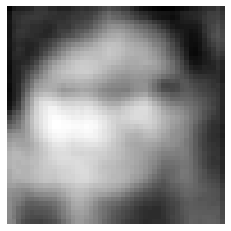

neutral


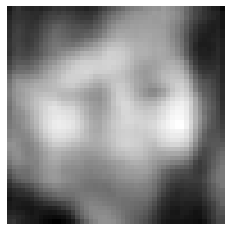

happiness


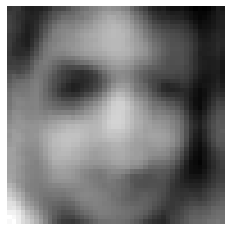

neutral


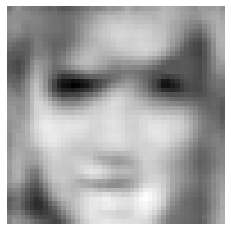

happiness


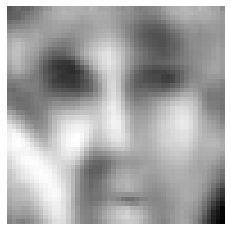

neutral


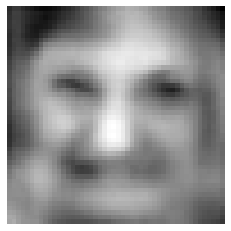

anger


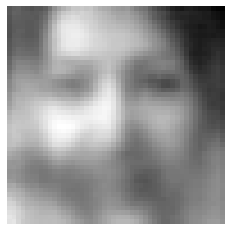

sadness


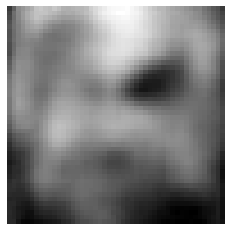

neutral


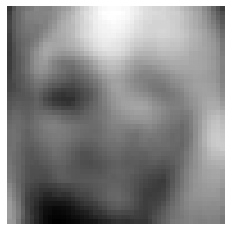

surprise


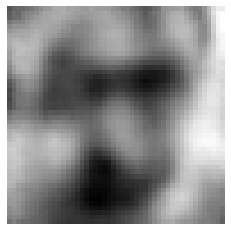

In [63]:
for recon, emotion in zip(recons, emotions):
    print(labels[np.argmax(emotion)])
    plt.imshow(recon.reshape((48,48)), cmap='gray')
    plt.axis('off')
    plt.show()

Cluster0, majority neutral, 0.597 purity, 534 elts
neutral


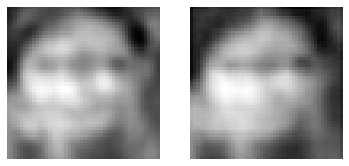

Cluster1, majority neutral, 0.443 purity, 201 elts
neutral


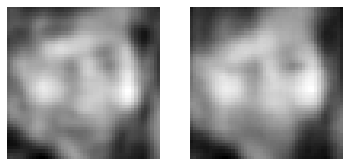

Cluster2, majority neutral, 0.292 purity, 391 elts
happiness


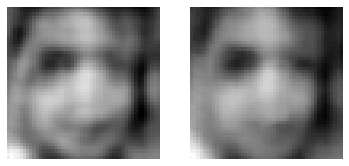

Cluster3, majority surprise, 0.718 purity, 354 elts
neutral


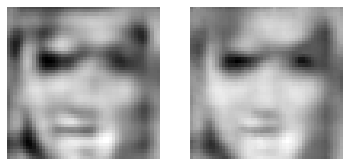

Cluster4, majority happiness, 0.914 purity, 406 elts
happiness


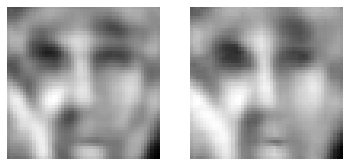

Cluster5, majority neutral, 0.456 purity, 274 elts
neutral


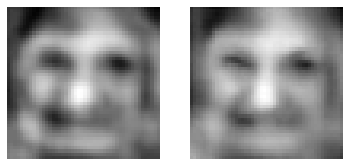

Cluster6, majority neutral, 0.427 purity, 302 elts
anger


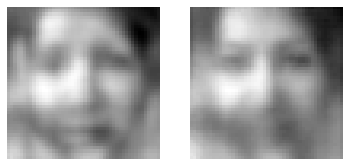

Cluster7, majority neutral, 0.517 purity, 526 elts
sadness


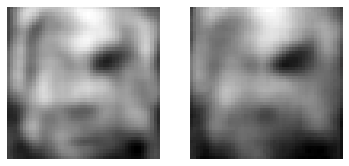

Cluster8, majority neutral, 0.416 purity, 322 elts
neutral


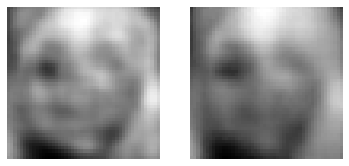

Cluster9, majority happiness, 0.333 purity, 279 elts
surprise


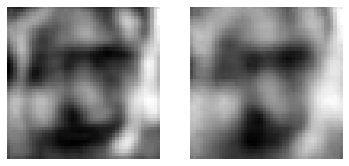

In [75]:
faces, emotions = emotion_vae.decode(embeddings)

for c_id, recon, emotion in zip(range(len(centroids)), recons, emotions):
    c_idx = clusters == c_id
    c_faces = faces[c_idx]
    c_face_avg = np.mean(c_faces, axis=0)
    c_yvals = yvals_argmax[c_idx]
    c_emo = np.argmax(np.bincount(c_yvals))
    c_purity = np.max(np.bincount(c_yvals)) / c_yvals.shape[0]
    
    fig, axs = plt.subplots(1,2)
    print(f"Cluster{c_id}, majority {labels[c_emo]}, {np.round(c_purity,3)} purity, {c_yvals.shape[0]} elts")
    axs[0].imshow(c_face_avg.reshape((48,48)), cmap='gray')
    axs[0].axis('off')
    print(labels[np.argmax(emotion)])
    axs[1].imshow(recon.reshape((48,48)), cmap='gray')
    axs[1].axis('off')
    
    plt.show()

In [191]:
k = 10

# kmeans
centroids, clusters = kmeans(embeddings, k)

# latent averages
cen_faces, cen_emotions = emotion_vae.decode(centroids)

# predicted averages
all_faces, all_emotions = emotion_vae.decode(embeddings)
avg_faces, avg_emotions = [], []
tru_faces, tru_emotions = [], []
for c_id in range(k):
    c_idx = clusters == c_id
    avg_face = np.mean(all_faces[c_idx], axis=0)
    tru_face = np.mean(test_faces[c_idx], axis=0)
    avg_emotion = np.mean(all_emotions[c_idx], axis=0)
    tru_emotion = np.mean(yvals[c_idx], axis=0)
    avg_faces.append(avg_face)
    avg_emotions.append(avg_emotion)
    tru_faces.append(tru_face)
    tru_emotions.append(tru_emotion)
avg_faces = np.array(avg_faces)
avg_emotions = np.array(avg_emotions)
tru_faces = np.array(tru_faces)
tru_emotinos = np.array(tru_emotions)

# Get cluster purity:
# for c_id in range(k):
#     c_idx = clusters == c_id
#     c_yvals = yvals_argmax[c_idx]
#     c_emo = np.argmax(np.bincount(c_yvals))
#     c_purity = np.max(np.bincount(c_yvals)) / c_yvals.shape[0]
#     print(f"Cluster{c_id}, majority {labels[c_emo]}, {np.round(c_purity,3)} purity, {c_yvals.shape[0]} elts")

7.961922839317188
1.085751193595898
0.7046813154560955
0.5026837748996537
0.3964389769453096
0.29301698189133546
0.2341489836786514
0.18559904620961826
0.1795538498117178
0.14823721196233125
0.13590459688195955
0.10941113519860968
0.10057908805213425
0.09713558089265349
0.08785890456580019
0.09212037155103689
0.08463869010629975
0.07381915584657492
0.07091702657520732
0.058252395289137573
0.05507091515846567
0.03750832539049683
0.044316018454974196
0.047573879983224966
0.043523537562485684
0.05108882644785375
0.05201150269630132
0.04470672624073346
0.041573551556416906
0.03615567248128489
0.03473126889267346
0.021254559337756836
0.02977228342767584
0.03463766877241991
0.02298377989677577
0.019719220311040182
0.006085257831336017


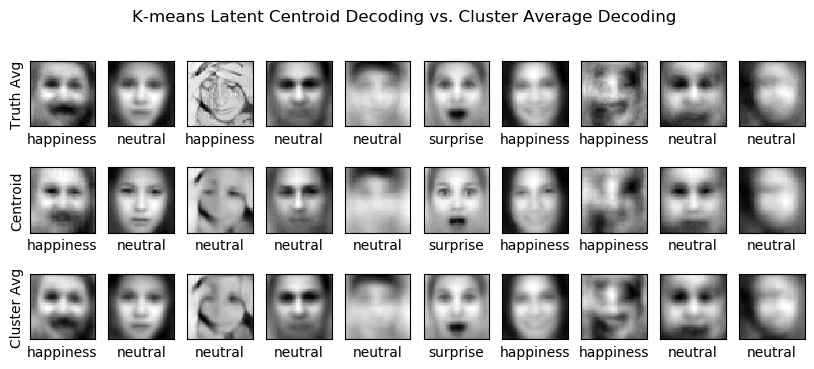

In [192]:
fig, axs = plt.subplots(3, k, figsize=(10,4), dpi=100)
fig.suptitle('K-means Latent Centroid Decoding vs. Cluster Average Decoding')
for i in range(k):
    axs[0][i].imshow(tru_faces[i].reshape((48,48)), cmap='gray')
    tru_emo = labels[np.argmax(tru_emotions[i])]
    axs[1][i].imshow(cen_faces[i].reshape((48,48)), cmap='gray')
    cen_emo = labels[np.argmax(cen_emotions[i])]
    axs[2][i].imshow(avg_faces[i].reshape((48,48)), cmap='gray')
    avg_emo = labels[np.argmax(avg_emotions[i])]
    if i == 0:
        axs[0][i].set_ylabel('Truth Avg')
        axs[1][i].set_ylabel('Centroid')
        axs[2][i].set_ylabel('Cluster Avg')
    axs[0][i].set_xlabel(tru_emo)
    axs[1][i].set_xlabel(cen_emo)
    axs[2][i].set_xlabel(avg_emo)
    for j in range(3):
        axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])
    axs[1][i].set_xlabel(avg_emo)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])
    
plt.savefig('kmeans_faces.png')
plt.show()

In [193]:
# Get cluster purity:
for c_id in range(k):
    c_idx = clusters == c_id
    true_yvals = test_yvals[c_idx]
    dcod_yvals = all_emotions[c_idx]
    true_yvals_argmax = np.array([np.argmax(yval) for yval in true_yvals])
    dcod_yvals_argmax = np.array([np.argmax(yval) for yval in dcod_yvals])
    true_emo_maj = labels[np.argmax(np.bincount(true_yvals_argmax))]
    dcod_emo_maj = labels[np.argmax(np.bincount(dcod_yvals_argmax))]
    true_purity = np.max(np.bincount(true_yvals_argmax)) / true_yvals_argmax.shape[0]
    dcod_purity = np.max(np.bincount(dcod_yvals_argmax)) / dcod_yvals_argmax.shape[0]
    print(f"Cluster{c_id} | truth: {true_emo_maj}, {true_purity} | pred: {dcod_emo_maj}, {dcod_purity} | {true_yvals.shape[0]} elts")

Cluster0 | truth: happiness, 0.4013452914798206 | pred: happiness, 0.49327354260089684 | 446 elts
Cluster1 | truth: neutral, 0.6011904761904762 | pred: neutral, 0.7827380952380952 | 336 elts
Cluster2 | truth: happiness, 0.5 | pred: sadness, 0.5 | 2 elts
Cluster3 | truth: neutral, 0.5474209650582362 | pred: neutral, 0.757071547420965 | 601 elts
Cluster4 | truth: neutral, 0.4126984126984127 | pred: neutral, 0.6253968253968254 | 315 elts
Cluster5 | truth: surprise, 0.6802168021680217 | pred: surprise, 0.7940379403794038 | 369 elts
Cluster6 | truth: happiness, 0.5844660194174758 | pred: happiness, 0.6718446601941748 | 515 elts
Cluster7 | truth: happiness, 0.29523809523809524 | pred: happiness, 0.3968253968253968 | 315 elts
Cluster8 | truth: neutral, 0.42025316455696204 | pred: neutral, 0.5949367088607594 | 395 elts
Cluster9 | truth: neutral, 0.5050847457627119 | pred: neutral, 0.6440677966101694 | 295 elts


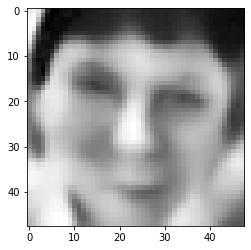

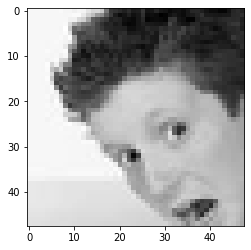

In [143]:
plt.imshow(all_faces[20].reshape((48,48)), cmap='gray')
plt.show()
plt.imshow(test_faces[20].reshape((48,48)), cmap='gray')
plt.show()

In [194]:
len(test_faces)

3589